In [8]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
import eleanor
from tqdm import tnrange

from scipy.interpolate import RectBivariateSpline

In [9]:
def pathLookup(ccd, camera, sector):
    """
    Gets the datestring and the subdirectory for the specified PRF. 
    The datestring and directory name can be found from the ccd, camera and sector.
    
    Inputs
    -------
    ccd
        (int) number of the TESS ccd. Accepts values from 1-4.
    camera
        (int) number of the TESS camera. Accepts values from 1-4
    sector
        (int) number of the TESS sector. Accepts values of 1 and above.
    
    Returns
    -------
    datestring
        (str) Date string used in the TESS prf files name.
    add_path
        (str) Directory name where the TESS PRF is stored. (e.g. "/start_s0001/")
    """ 
    if sector < 1:
        raise ValueError("Sector must be greater than 0.")
    if (camera > 4) | (ccd > 4):
        raise ValueError("Camera or CCD is larger than 4.")

    if sector <= 3:
        add_path = "/start_s0001/"
        datestring = "2018243163600"

        if camera >= 3:
            datestring = "2018243163601"
        elif (camera == 2) & (ccd == 4):
            datestring = "2018243163601"
        
    else:
        add_path = "/start_s0004/"
        datestring = "2019107181900"
        if (camera == 1) & (ccd >= 2):
            datestring = "2019107181901"
        elif (camera == 2):
            datestring = "2019107181901"
        elif (camera == 3) & (ccd >= 2) :
            datestring = "2019107181902"
        elif (camera == 4):
            datestring = "2019107181902"

    return datestring, add_path

In [10]:
def readOnePrfFitsFile(ccd, camera, col, row, path, datestring):
    """
    reads in the full, interleaved prf Array for a single row,col,ccd,camera location.
    
    Inputs
    -------
    ccd
        (int) CCD number
    camera
        (int) Camera number
    col
        (float) Specific column where the PRF was sampled.
    row
        (float) Specific row where the PRF was sampled.
    path
        (string) The full path of the data file. Can be the MAST Web address
        
    Returns
    ------
    prfArray
        (np array) Full 117 x 117 interleaved prf Array for the requested file.      
    """
        
    fn = "cam%u_ccd%u/tess%13s-prf-%1u-%1u-row%04u-col%04u.fits" % \
        (camera, ccd, datestring, camera, ccd, row, col)

    filepath = os.path.join(path, fn)
    hdulistObj = fits.open(filepath)
    prfArray = hdulistObj[0].data

    return prfArray

def determineFourClosestPrfLoc(col, row):
    """
    Determine the four pairs of col,row positions of your target. 
    These are specific to TESS and where they chose to report their PRFs.
    Inputs
    ------
    col
        (float) Column position
    row
        (float) Row position.
    
    Returns
    -------
    imagePos
        (list) A list of (col,row) pairs.
    """

    posRows = np.array([1, 513, 1025, 1536, 2048])
    posCols = np.array([45, 557, 1069, 1580,2092])

    difcol = np.abs(posCols - col)
    difrow = np.abs(posRows - row)

    # Expand out to the four image position to interpolate between,
    # Return as a list of tuples.
    imagePos = []
    for r in posRows[np.argsort(difrow)[0:2]]:
        for c in posCols[np.argsort(difcol)[0:2]]:
            imagePos.append((c,r))

    return imagePos

In [11]:
def getOffsetsFromPixelFractions(col, row):
    """
    Determine just the fractional part (the intra-pixel part) of the col,row position.  
    For example, if (col, row) = (123.4, 987.6), then
    (colFrac, rowFrac) = (.4, .6). 
    
    Function then returns the offset necessary for addressing the interleaved PRF array.
    to ensure you get the location appropriate for your sub-pixel values.
    
    Inputs
    ------
    col
        (float) Column position
    row
        (float) Row position.
    
    Returns
    ------
    (colFrac, rowFrac)
       (int, int) offset necessary for addressing the interleaved PRF array.
    """
    gridSize = 9

    colFrac = np.remainder(float(col), 1)
    rowFrac = np.remainder(float(row), 1)

    colOffset = gridSize - np.round(gridSize * colFrac) - 1
    rowOffset = gridSize - np.round(gridSize * rowFrac) - 1
    
    return int(colOffset), int(rowOffset)

def getRegSampledPrfFitsByOffset(prfArray, colOffset, rowOffset):
    """
    The 13x13 pixel PRFs on at each grid location are sampled at a 9x9 intra-pixel grid, to
    describe how the PRF changes as the star moves by a fraction of a pixel in row or column.
    To extract out a single PRF, you need to address the 117x117 array in a funny way
    (117 = 13x9). Essentially you need to pull out every 9th element in the array, i.e.

    .. code-block:: python

        img = array[ [colOffset, colOffset+9, colOffset+18, ...],
                     [rowOffset, rowOffset+9, ...] ]
    
    Inputs
    ------
    prfArray
        117x117 interleaved PRF array
    colOffset, rowOffset
        The offset used to address the column and row in the interleaved PRF
    
    Returns
    ------
    prf
        13x13 PRF image for the specified column and row offset
    
    """
    gridSize = 9

    assert colOffset < gridSize
    assert rowOffset < gridSize

    # Number of pixels in regularly sampled PRF. Should be 13x13
    nColOut, nRowOut = prfArray.shape
    nColOut /= float(gridSize)
    nRowOut /= float(gridSize)

    iCol = colOffset + (np.arange(nColOut) * gridSize).astype(np.int)
    iRow = rowOffset + (np.arange(nRowOut) * gridSize).astype(np.int)

    tmp = prfArray[iRow, :]
    prf = tmp[:,iCol]

    return prf

In [12]:
def interpolatePrf(regPrfArray, col, row, imagePos):
    """
    Interpolate between 4 images to find the best PRF at the specified column and row.
    This is a simple linear interpolation.
    
    Inputs
    -------
    regPrfArray 
        13x13x4 prf image array of the four nearby locations.
        
    col and row 
        (float) the location to interpolate to.
        
    imagePos
        (list) 4 floating point (col, row) locations
        
    Returns
    ----
    Single interpolated PRF image.
    """
    p11, p21, p12, p22 = regPrfArray
    c0 = imagePos[0][0]
    c1 = imagePos[1][0]
    r0 = imagePos[0][1]
    r1 = imagePos[2][1]

    assert c0 != c1
    assert r0 != r1

    dCol = (col-c0) / (c1-c0)
    dRow = (row-r0) / (r1 - r0)

    # Intpolate across the rows
    tmp1 = p11 + (p21 - p11) * dCol
    tmp2 = p12 + (p22 - p12) * dCol

    # Interpolate across the columns
    out = tmp1 + (tmp2-tmp1) * dRow
    return out

In [13]:
def getNearestPrfFits(col, row, ccd, camera, sector, path):
    """
    Main Function
    Return a 13x13 PRF image for a single location. No interpolation
    
    This function is identical to getPrfAtColRowFits except it does not perform the interpolation step.
    
    Inputs
    ---------
    col, row
        (floats) Location on CCD to lookup. The origin of the CCD is the bottom left.
        Increasing column increases the "x-direction", and row increases the "y-direction"
        The column coordinate system starts at column 45.
    ccd
        (int) CCD number. There are 4 CCDs per camera
    camera
        (int) Camera number. The instrument has 4 cameras
    sector
        (int)  Sector number, greater than or equal to 1.

    Returns
    ---------
    A 13x13 numpy image array of the nearest PRF to the specifed column and row.
    """
    col = float(col)
    row = float(row)
    prfImages = []
    
    # Determine a datestring in the file name and the path based on ccd/camer/sector
    datestring, addPath = pathLookup(ccd, camera, sector)
    path = path + addPath
    
    # Convert the fractional pixels to the offset required for the interleaved pixels.
    colOffset, rowOffset = getOffsetsFromPixelFractions(col, row)
    
    # Determine the 4 (col,row) locations with exact PRF measurements.
    imagePos = determineFourClosestPrfLoc(col, row)
    bestPos = imagePos[0]
    prfArray = readOnePrfFitsFile(ccd, camera, bestPos[0], bestPos[1], path, datestring)
            
    prfImage = getRegSampledPrfFitsByOffset(prfArray, colOffset, rowOffset)       

    return prfArray, prfImage

In [14]:
def getPrfAtColRowFits(col, row, ccd, camera, sector, path):
    """
    Main Function
    Lookup a 13x13 PRF image for a single location
    
    Inputs
    ---------
    col, row
        (floats) Location on CCD to lookup. The origin of the CCD is the bottom left.
        Increasing column increases the "x-direction", and row increases the "y-direction"
        The column coordinate system starts at column 45.
    ccd
        (int) CCD number. There are 4 CCDs per camera
    camera
        (int) Camera number. The instrument has 4 cameras
    sector
        (int)  Sector number, greater than or equal to 1.
    path
        (str) Directory or URL where the PRF fits files are located

    Returns
    ---------
    A 13x13 numpy image array of the interpolated PRF.
    """
    col = float(col)
    row = float(row)
    prfImages = []
    
    # Determine a datestring in the file name and the path based on ccd/camera/sector
    datestring, subDirectory = pathLookup(ccd, camera, sector)
    path = path + subDirectory
    
    # Convert the fractional pixels to the offset required for the interleaved pixels.
    colOffset, rowOffset = getOffsetsFromPixelFractions(col, row)
    
    # Determine the 4 (col,row) locations with exact PRF measurements.
    imagePos = determineFourClosestPrfLoc(col, row)

    # Loop over the 4 locations and read in each file and extract the sub-pixel location.
    for pos in imagePos:
            prfArray = readOnePrfFitsFile(ccd, camera, pos[0], pos[1], path, datestring)
            
            #img = getRegSampledPrfFitsByOffset(prfArray, colOffset, rowOffset)       
            prfImages.append(prfArray)

    # Simple linear interpolate across the 4 locations.
    interpolatedPrf = interpolatePrf(prfImages, col, row, imagePos)

    return interpolatedPrf

In [15]:
# This is the directory where MAST stores the prf FITS files.
path = "https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/"


In [39]:
prf = getPrfAtColRowFits(939.361, 1095.571, 1, 4, 14, path)  # col, row, ccd, camera, sector

In [17]:
def make_prf(col, row, ccd, camera, sector, xshift, yshift):
    return getPrfAtColRowFits(col, row, ccd, camera, sector, path)

def move_prf(prf, xshift, yshift):
   
    x = np.linspace(0.0, 13.0, 117)
    y = np.linspace(0.0, 13.0, 117)
    X, Y = np.meshgrid(x, y)
    
    interp_spline = RectBivariateSpline(y, x, prf)

    dx2, dy2 = 0.01, 0.01
    x2 = np.arange(0.0-xshift, 13.0-xshift, dx2)
    y2 = np.arange(0.0-yshift, 13.0-yshift, dy2)
    X2, Y2 = np.meshgrid(x2,y2)
    Z2 = interp_spline(y2, x2)
    
    
    return np.sum(np.reshape(Z2, (13,100,13,100)), axis=(1,3))/100/100
    


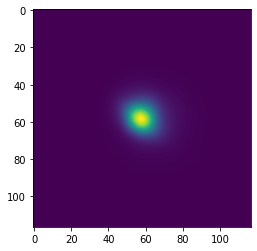

In [41]:
plt.imshow(prf) 

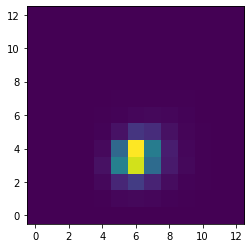

In [18]:
shifted_prf2 = move_prf(prf, 0.0, -2.49)
shifted_prf1 = move_prf(prf, 0.0, 2.51)


plt.imshow(shifted_prf2, origin='lower')

    

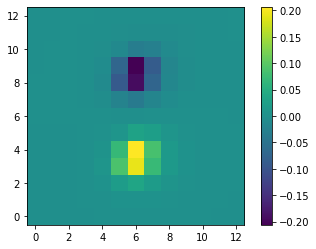

In [19]:
plt.imshow(shifted_prf2-shifted_prf1, origin='lower')
plt.colorbar()

In [20]:
from tqdm import trange

In [24]:
postflux = fits.open(os.path.expanduser('~/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-1-1-cal-0314-0322_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-1-1-cal-0314-0322_tess_v2_pc.fits'))

In [25]:
postcard = postflux[2].data + 0.0
time = postflux[1].data['tstart']


offset_y_1 = 0.5  # this should really be an array that tracks the row and column motions 
offset_x_1 = 0.7  # of the centroid of a star. You can calculate those yourself by taking a bright isolated star
                  # and calculating the center of mass at each cadence and dropping that in, or running eleanor and
                  # taking data.x_com (I think) would get you the same thing and you can drop in those offsets.

signal_1 = 300+56.0*np.sin(time*2*np.pi/4.8)  # simple sine wave, you can change it to something more realistic


for i in trange(np.shape(postcard)[0]):
    postcard[i,63:76,33:46] += signal_1[i]*move_prf(prf, offset_x_1, offset_y_1)



100%|██████████| 1196/1196 [02:44<00:00,  7.27it/s]


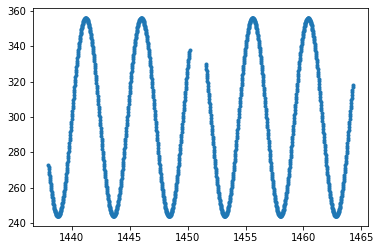

In [26]:
plt.plot(time, signal_1, '.')

In [17]:
#orig_data = fits.open('/Users/ozymandias1/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-1-1-cal-0314-0322_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-1-1-cal-0314-0322_tess_v2_pc.fits')

In [27]:
postflux[2].data = postcard + 0.0

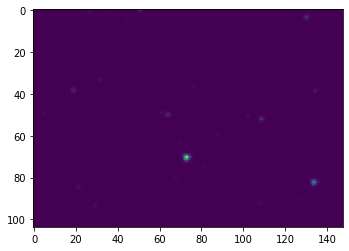

In [34]:
plt.imshow(postcard[1000,:,:])

In [19]:
#postflux.writeto('test_postcard_20200513.fits', overwrite=True)

In [20]:
postflux.close()